In [11]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [12]:
import mst_decoder as decoder
import mst_decoder.simulate as sim

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

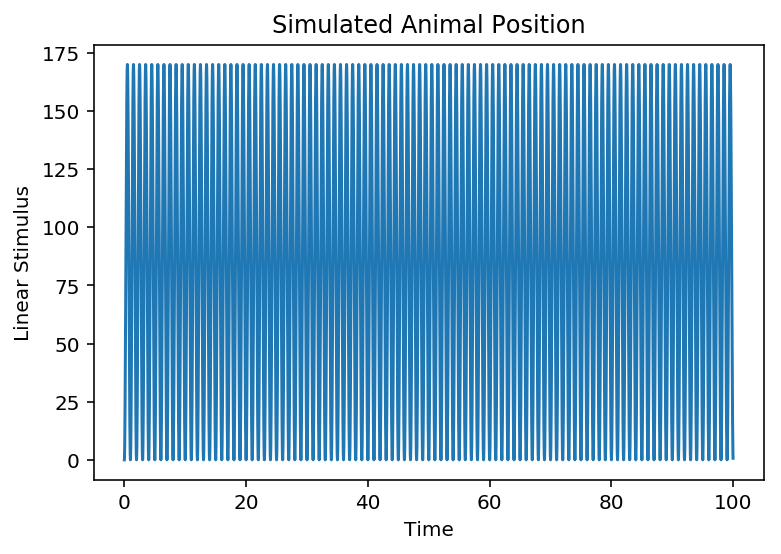

In [128]:
SAMPLING_FREQUENCY = 50
N_SAMPLES = SAMPLING_FREQUENCY * 100
TRACK_HEIGHT = 170

time = sim.simulate_time(N_SAMPLES, SAMPLING_FREQUENCY)
stimulus = sim.simulate_linear_distance(time, TRACK_HEIGHT)
# stimulus = sim.simulate_nd_randomwalk(time, bounds=np.array([[-100, 100], [-100, 100]]), delta=45)

plt.plot(time, stimulus);
plt.ylabel('Linear Stimulus')
plt.xlabel('Time')
plt.title('Simulated Animal Position');

/home/mz/prj/mst-decoder/mst_decoder/simulate.py:76: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(unit, axis=0), axis=0)


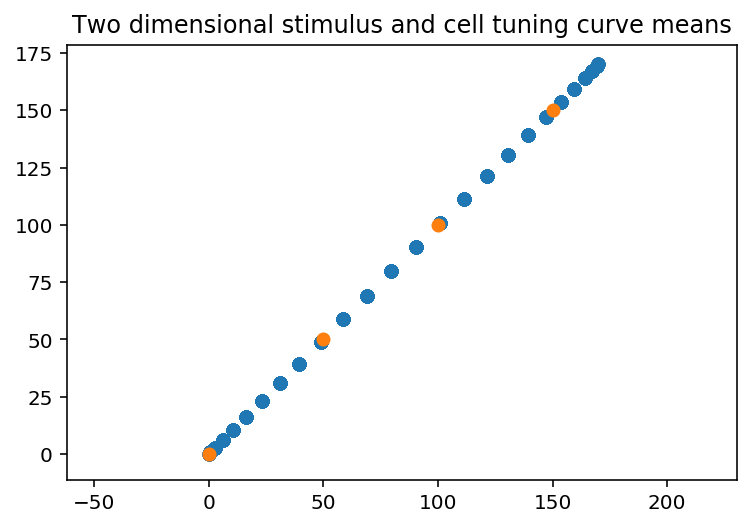

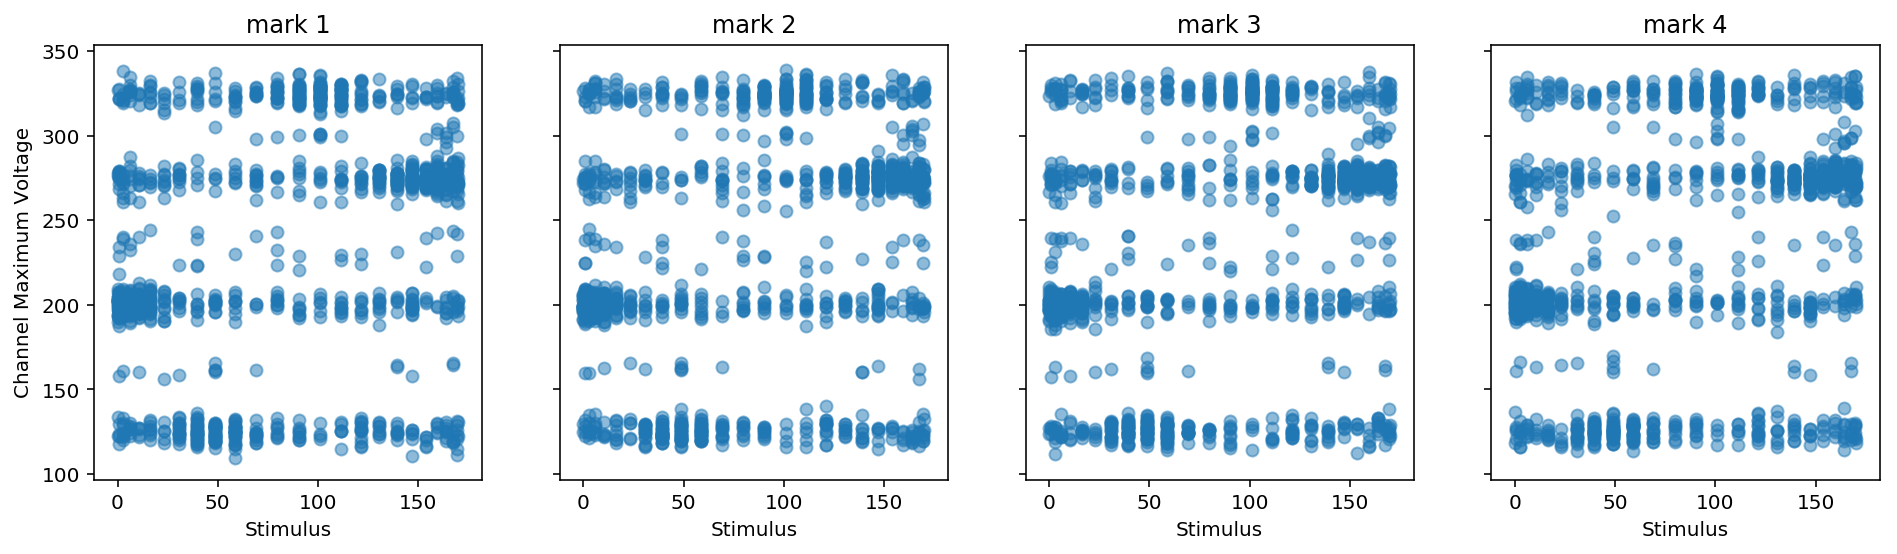

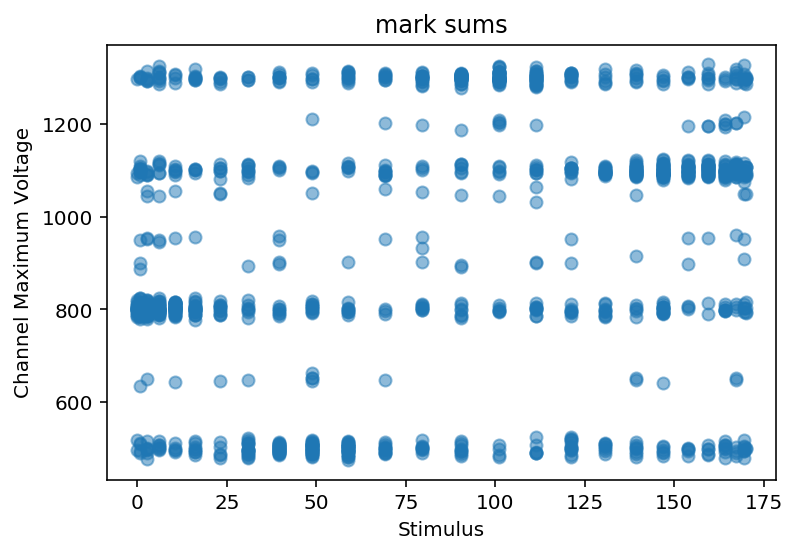

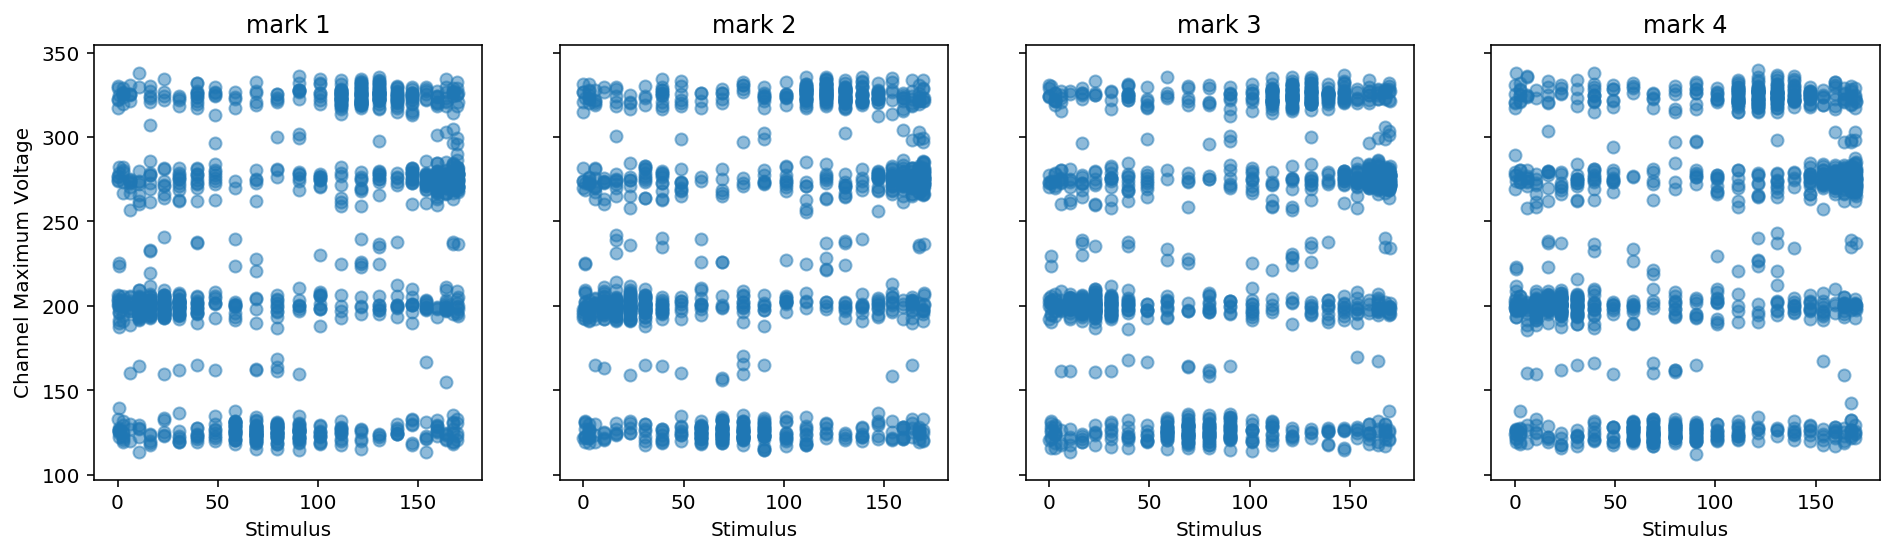

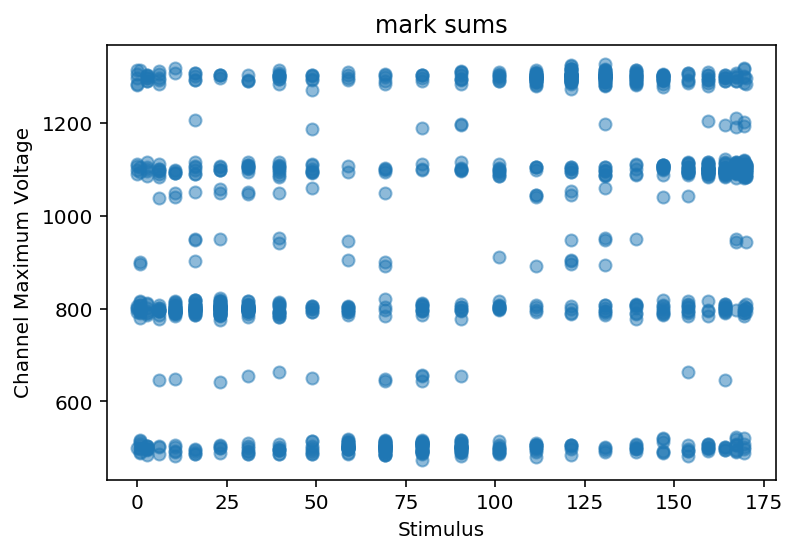

In [129]:
N_CELLS = 20

mark_means = np.array([200, 125, 325, 275])
place_field_means = np.stack((np.arange(0, 200, 50),
                              np.arange(25, 200, 50)))

signal_data = np.stack(
    [sim.simulate_multiunit(place_field_means[0], mark_means, stimulus, SAMPLING_FREQUENCY),
     sim.simulate_multiunit(place_field_means[1], mark_means, stimulus, SAMPLING_FREQUENCY)])
                        
ax = plt.figure().gca()
ax.axis('equal')
ax.scatter(stimulus, stimulus, alpha=0.05);
ax.scatter(place_field_means[0], place_field_means[0])
ax.set_title('Two dimensional stimulus and cell tuning curve means')

for s in signal_data:
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
    for ind, (ax, m) in enumerate(zip(axes, s.T)):
        ax.scatter(stimulus, m, alpha=0.5)
        ax.set_xlabel('Stimulus')
        ax.set_title('mark {0}'.format(ind + 1))
    axes[0].set_ylabel('Channel Maximum Voltage');
    ax = plt.figure().gca()
    ax.scatter(stimulus, np.sum(s, axis=-1), alpha=0.5)
    ax.set_xlabel('Stimulus')
    ax.set_title('mark sums')
    ax.set_ylabel('Channel Maximum Voltage');

In [130]:
d = decoder.ClusterlessDecoder(
    stimulus=stimulus,
    spike_marks=signal_data)

# 7.38 s ± 50.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) single tetrode 20 cells
d.fit()

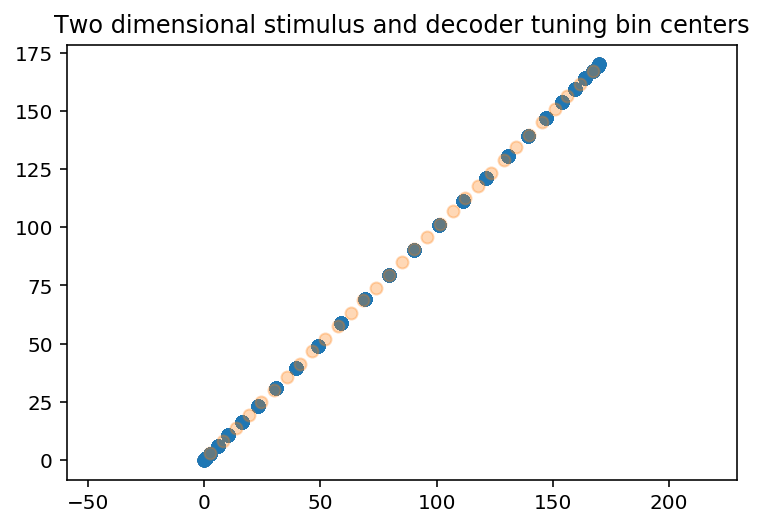

In [131]:
ax = plt.figure().gca()
ax.axis('equal')
ax.scatter(stimulus, stimulus, alpha=0.05);
ax.scatter(d.tuning_bin_grid[:, 0], d.tuning_bin_grid[:, 0], alpha=0.3);
ax.set_title('Two dimensional stimulus and decoder tuning bin centers');

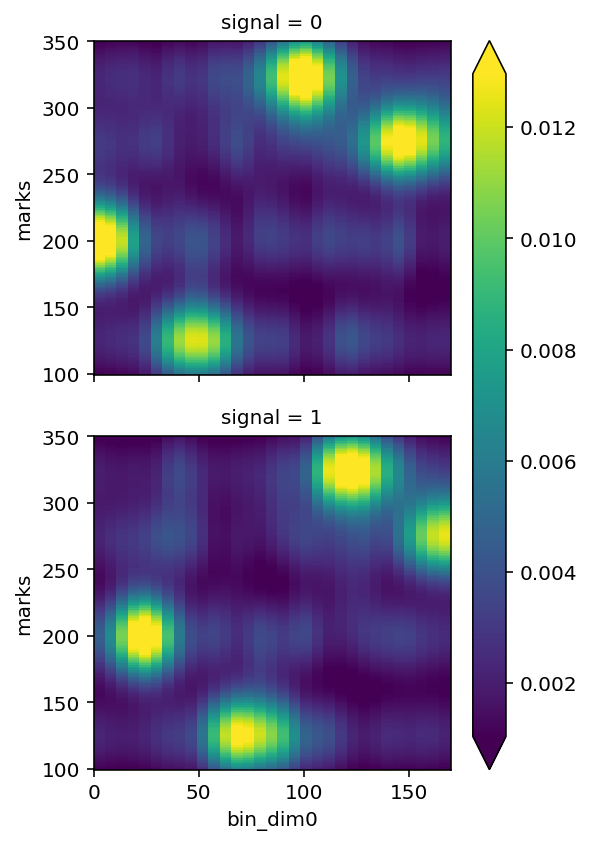

In [132]:
d.plot_observation_model();

In [133]:
mark_means_test = mark_means * 1.05
signal_data_test = [sim.simulate_multiunit(place_field_means, mark_means_test, stimulus, SAMPLING_FREQUENCY)]
prediction = d.predict(signal_data)
prediction

/home/mz/prj/mst-decoder/mst_decoder/simulate.py:76: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(unit, axis=0), axis=0)


<xarray.Dataset>
Dimensions:            (p_stimulus_bin: 31, time: 5000)
Coordinates:
    bin_dim0           (p_stimulus_bin) float64 2.742 8.226 13.71 19.19 ...
  * time               (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Dimensions without coordinates: p_stimulus_bin
Data variables:
    posterior_density  (time, p_stimulus_bin) float64 0.03355 0.03315 ...
    likelihood         (time, p_stimulus_bin) float64 0.6358 0.6282 0.6195 ...
    prior              (time, p_stimulus_bin) float64 0.03226 0.03226 ...

array([200, 125, 325, 275])

In [137]:
stim_pred = np.zeros_like(stimulus)
bin_pred = np.argmax(prediction['likelihood'], axis=-1)
for i in range(stim_pred.shape[0]):
    stim_pred[i] = d.tuning_bin_centers[0][bin_pred[i]]

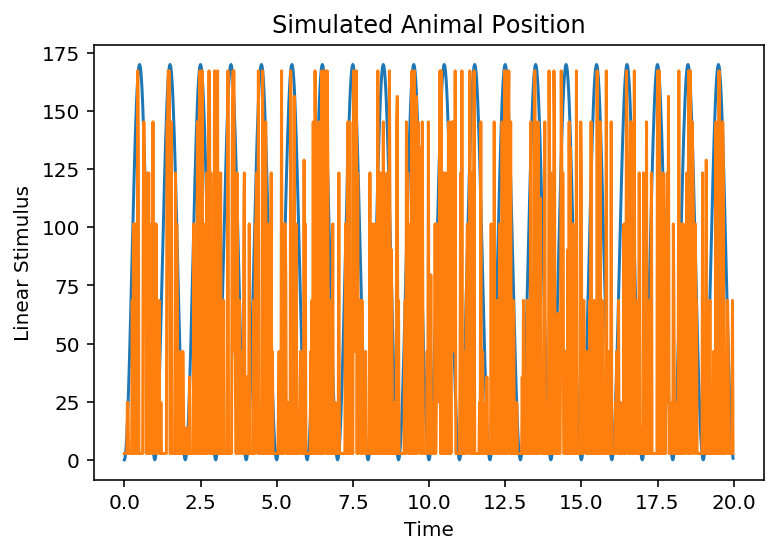

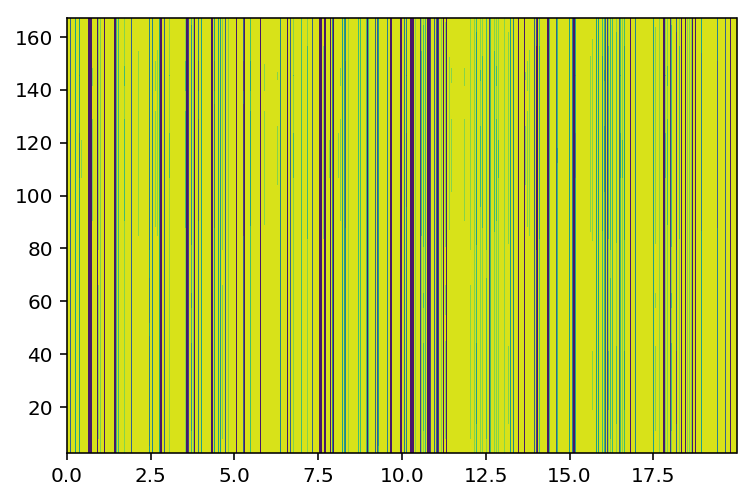

In [143]:
rmax=1000
plt.plot(time[0:rmax], stimulus[0:rmax]);
plt.plot(time[0:rmax], stim_pred[0:rmax])
plt.ylabel('Linear Stimulus')
plt.xlabel('Time')
plt.title('Simulated Animal Position');


ax = plt.figure().gca()
ax.contourf(time[0:rmax], d.tuning_bin_centers[0], prediction['likelihood'][0:rmax].T)

In [144]:
prediction['likelihood'][0:rmax].T

<xarray.DataArray 'likelihood' (p_stimulus_bin: 31, time: 1000)>
array([[  6.357528e-01,   6.357528e-01,   6.357528e-01, ...,   6.357528e-01,
          2.427958e-09,   6.357528e-01],
       [  6.281998e-01,   6.281998e-01,   6.281998e-01, ...,   6.281998e-01,
          2.217203e-09,   6.281998e-01],
       [  6.194938e-01,   6.194938e-01,   6.194938e-01, ...,   6.194938e-01,
          2.140235e-09,   6.194938e-01],
       ..., 
       [  6.149933e-01,   6.149933e-01,   6.149933e-01, ...,   6.149933e-01,
          2.527046e-09,   6.149933e-01],
       [  6.194871e-01,   6.194871e-01,   6.194871e-01, ...,   6.194871e-01,
          2.489475e-09,   6.194871e-01],
       [  6.302714e-01,   6.302714e-01,   6.302714e-01, ...,   6.302714e-01,
          2.241804e-09,   6.302714e-01]])
Coordinates:
    bin_dim0  (p_stimulus_bin) float64 2.742 8.226 13.71 19.19 24.68 30.16 ...
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Dimensions without coordinates: p_stimul

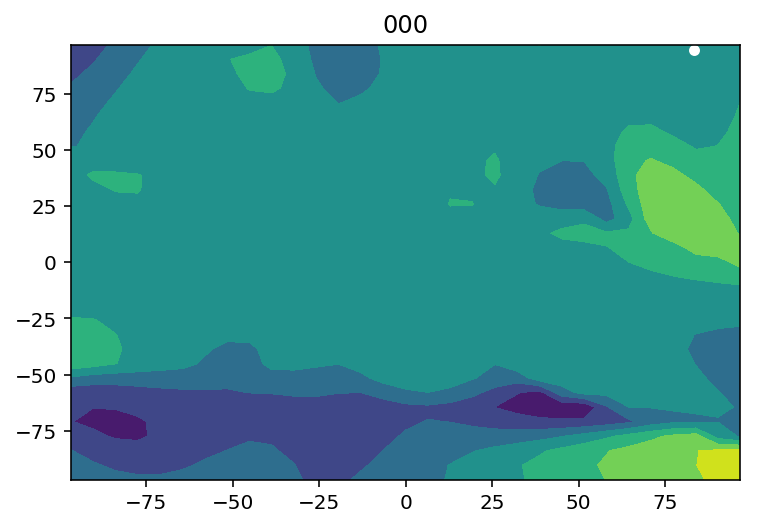

In [235]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
fig,ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.contourf(d.tuning_bin_centers[0], d.tuning_bin_centers[1], 
             res['likelihood'][i].values.reshape(31, 31))
    xy = stimulus[i]
#     x = kde.axes[1].shape[0] * (xy[0] - np.min(kde.axes[1])) / (np.max(kde.axes[1])- np.min(kde.axes[1]))
#     y = kde.axes[2].shape[0] * (xy[1] - np.min(kde.axes[2])) / (np.max(kde.axes[2])- np.min(kde.axes[2]))
    ax.scatter(xy[0], xy[1], c='white', s=20)
    ax.set_title('%03d'%(i)) 
    return ax

interval = 0.05#in seconds     
ani = animation.FuncAnimation(fig,animate,res['time'].shape[0] // 100,interval=interval*1e+3,blit=False)

HTML(ani.to_html5_video())